In [464]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [423]:
# 1. Load the cleaned datasets
df_sales = pd.read_csv('../data/cleaned/Cleaned_Sales.csv')
df_products = pd.read_csv('../data/cleaned/Cleaned_Products.csv')

# 2. Extract specific columns and join tables
# Logic: We bridge Sales to Products using 'ProductKey'
df_clv_raw = df_sales[['OrderDate', 'CustomerKey', 'OrderQuantity', 'ProductKey']].merge(
    df_products[['ProductKey', 'ProductCost', 'ProductPrice']], 
    on='ProductKey', 
    how='left'
)

# 3. Obtain Profit (Monetary Value)
# Formula: (Price - Cost) * Quantity
df_clv_raw['Profit'] = (df_clv_raw['ProductPrice'] - df_clv_raw['ProductCost']) * df_clv_raw['OrderQuantity']

# 4. Final Dataframe Selection
df_final = df_clv_raw[['OrderDate', 'CustomerKey', 'Profit']]

In [424]:
# 1. Extract unique keys from both dataframes
sales_keys = set(df_sales['ProductKey'].unique())
product_keys = set(df_products['ProductKey'].unique())

# 2. Find keys present in Sales but missing from Products
orphaned_keys = sales_keys - product_keys

# 3. Report findings
if not orphaned_keys:
    print("✅ Success: All ProductKeys in Sales exist in the Products table.")
else:
    print(f"⚠️ Warning: Found {len(orphaned_keys)} orphaned ProductKeys.")
    print(f"Missing Keys: {list(orphaned_keys)[:10]}...") # Show first 10
    
    # 4. Check how many rows are affected
    affected_rows = df_sales[df_sales['ProductKey'].isin(orphaned_keys)].shape[0]
    print(f"Impact: {affected_rows} rows in Sales are missing product info.")

⚠️ Warning: Found 2 orphaned ProductKeys.
Missing Keys: [np.int64(480), np.int64(529)]...
Impact: 4573 rows in Sales are missing product info.


In [425]:
df_final.head()

,OrderDate,CustomerKey,Profit
0,01-01-2015,29255,1406.9758
1,01-01-2015,14657,285.9519
2,01-01-2015,26782,285.9519
3,01-01-2015,11455,1476.8956
4,02-01-2015,15048,1406.9758


In [426]:
c=df_final.groupby('CustomerKey')['Profit'].sum()
pd.DataFrame(c).describe()

,Profit
count,16111.000000
mean,599.235593
std,772.496414
min,0.000000
25%,42.311300
50%,213.843200
75%,943.288200
max,5073.333500


In [427]:
df_final.duplicated().sum()
df_final= df_final.dropna()
df= df_final.copy()

In [ ]:
# LIBRARIES -----
import pandas_flavor as pf
if not hasattr(pf, 'register_groupby_method'):
    pf.register_groupby_method = pf.register_dataframe_method
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True, format='mixed')
import pytimetk as tk
import lifetimes as lf
from lifetimes.plotting import plot_probability_alive_matrix

# Ensure OrderDate is datetime format for lifetimes to process
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# TRANSFORM DATA -----
df_core = lf.utils.summary_data_from_transaction_data(
    df,
    customer_id_col     = 'CustomerKey',  # Your unique identifier
    datetime_col        = 'OrderDate',    # Your timestamp
    monetary_value_col  = 'Profit',       # Your calculated value
)
df_core = df_core.reset_index()

In [429]:
df_core.head()

,CustomerKey,frequency,recency,T,monetary_value
0,11000,1.0,102.0,445.0,981.0827
1,11001,0.0,0.0,345.0,0.0000
2,11002,1.0,142.0,449.0,923.7485
3,11003,1.0,65.0,296.0,941.5512
4,11004,1.0,166.0,505.0,1002.9864


In [430]:
df_core= df_core[df_core['frequency']!=0]
summary_df= df_core.copy()

In [431]:
summary_df.columns

Index(['CustomerKey', 'frequency', 'recency', 'T', 'monetary_value'], dtype='object')

In [432]:
df_core.describe().round(1)

,CustomerKey,frequency,recency,T,monetary_value
count,5075.0,5075.0,5075.0,5075.0,5075.0
mean,16833.9,1.3,362.5,514.1,529.8
std,4699.1,1.3,216.8,216.7,374.5
min,11000.0,1.0,1.0,16.0,2.9
25%,13007.5,1.0,181.0,342.5,196.3
50%,15480.0,1.0,349.0,507.0,472.3
75%,19784.5,1.0,532.0,691.0,938.8
max,29412.0,22.0,900.0,911.0,1955.4


In [433]:
summary_df

,CustomerKey,frequency,recency,T,monetary_value
0,11000,1.0,102.0,445.0,981.0827
2,11002,1.0,142.0,449.0,923.7485
3,11003,1.0,65.0,296.0,941.5512
4,11004,1.0,166.0,505.0,1002.9864
5,11005,1.0,138.0,476.0,981.7211
...,...,...,...,...,...
15786,29279,1.0,789.0,864.0,313.7647
15881,29388,1.0,170.0,527.0,223.2458
15882,29389,1.0,227.0,516.0,196.3404
15883,29390,1.0,195.0,485.0,196.3404


In [434]:
# 1. IDENTIFY OUTLIER INDICES
high_frequentist_df= df_core[df_core['frequency'] > 5]
high_montarist_df= df_core[df_core['monetary_value'] > 1000]
high_frequentist = df_core[df_core['frequency'] > 5].index
high_montarist    = df_core[df_core['monetary_value'] > 1000].index
whales_indices    = high_frequentist.union(high_montarist)

# 2. CREATE THE CORE DATAFRAME (Drop Whales and Wonders)
# First, drop the whales
df_core = df_core.drop(whales_indices)

# Second, remove "Wonders" (Frequency = 0) because Gamma-Gamma needs repeaters
df_core = df_core[df_core['frequency'] > 0].reset_index(drop=True)

### Model Selection

In [435]:
# 1.0 BG/NBD MODEL (Purchase Frequency) -----
bgf = lf.BetaGeoFitter(penalizer_coef=0.1) 
bgf.fit(df_core['frequency'], df_core['recency'], df_core['T'])

# 2.0 GAMMA-GAMMA MODEL (Monetary Value) -----
ggf = lf.GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(df_core['frequency'], df_core['monetary_value'])

# 3.0 PREDICTIVE SCORING -----
df_core['prob_alive'] = bgf.conditional_probability_alive(
    df_core['frequency'], df_core['recency'], df_core['T']
)

df_core['pred_purchases_90d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    90, df_core['frequency'], df_core['recency'], df_core['T']
)

df_core['exp_avg_profit'] = ggf.conditional_expected_average_profit(
    df_core['frequency'], df_core['monetary_value']
)

# 4.0 FINAL CLV CALCULATION (90-day horizon) -----
df_core['CLV_90d'] = ggf.customer_lifetime_value(
    bgf,
    df_core['frequency'],
    df_core['recency'],
    df_core['T'],
    df_core['monetary_value'],
    time=3,            # 3 months = 90 days
    discount_rate=0.01  # Monthly discount rate
)

print(df_core.sort_values('CLV_90d', ascending=False).head())

      CustomerKey  frequency  recency      T  monetary_value  prob_alive  \
216         11439        5.0    441.0  510.0      803.594900    0.943903   
208         11425        4.0    393.0  400.0      798.135775    0.954589   
759         12300        3.0    269.0  341.0      944.414167    0.901302   
1444        13650        2.0    211.0  211.0      937.225300    0.888137   
767         12308        3.0    346.0  385.0      939.644267    0.921737   

      pred_purchases_90d  exp_avg_profit     CLV_90d  
216             0.644083      838.913556  529.724091  
208             0.630260      842.467842  520.556850  
759             0.521371     1015.446968  519.042721  
1444            0.486253     1047.041164  499.156169  
767             0.498353     1010.323940  493.623259  


**Segmentation**

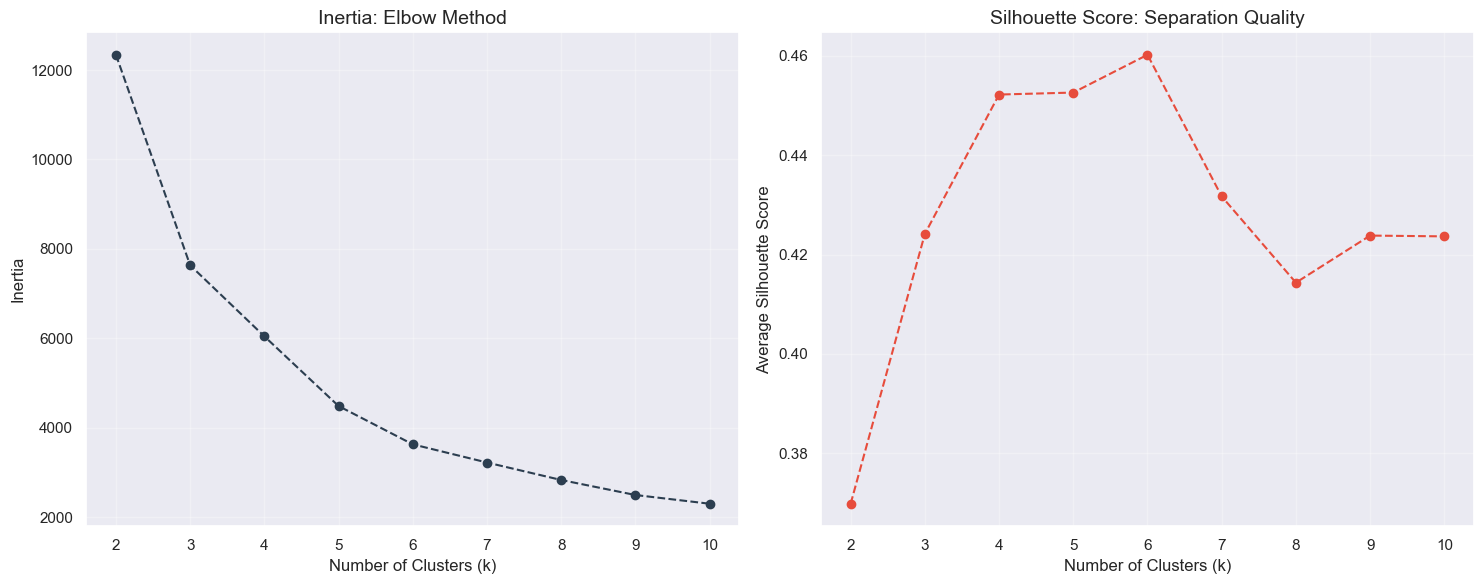

In [ ]:
# 1. SELECT DATA (Ensure you are using your Core set with CLV)
# We use RFM + CLV for behavioral segmentation
seg_df = df_core[['frequency', 'recency', 'monetary_value', 'CLV_90d']]

# 2. SCALE THE DATA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(seg_df)

# 3. ITERATE THROUGH K VALUES
ks = range(2, 11)
inertia, silhouette_scores = [], []

for k in ks:
    # n_init=10 is standard to avoid local minima
    model = KMeans(n_clusters=k, random_state=42, n_init=10).fit(scaled_data)
    inertia.append(model.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, model.labels_))

# 4. PLOTTING THE DIAGNOSTICS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Inertia (Elbow)
ax1.plot(ks, inertia, marker='o', linestyle='--', color='#2c3e50')
ax1.set_title('Inertia: Elbow Method', fontsize=14)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.grid(True, alpha=0.3)

# Plot Silhouette
ax2.plot(ks, silhouette_scores, marker='o', linestyle='--', color='#e74c3c')
ax2.set_title('Silhouette Score: Separation Quality', fontsize=14)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Average Silhouette Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [437]:
# 1. Select the Behavioral Features
features = ['frequency', 'recency', 'monetary_value', 'CLV_90d', 'prob_alive']
data_to_cluster = df_core[features]

# 2. Scale the data (Crucial: K-Means is distance-based)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_to_cluster)

# 3. Fit K-Means
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df_core['Segment'] = kmeans.fit_predict(scaled_features)

# 4. View the "DNA" of each segment
segment_summary = df_core.groupby('Segment')[features].mean().round(2)

In [438]:
df_core

,CustomerKey,frequency,recency,T,monetary_value,prob_alive,pred_purchases_90d,exp_avg_profit,CLV_90d,Segment
0,11000,1.0,102.0,445.0,981.0827,0.183298,0.045726,1240.776773,55.624135,2
1,11002,1.0,142.0,449.0,923.7485,0.213955,0.053086,1168.495650,60.815533,2
2,11003,1.0,65.0,296.0,941.5512,0.225920,0.070614,1190.939482,82.450858,2
3,11005,1.0,138.0,476.0,981.7211,0.198561,0.047537,1241.581603,57.865008,2
4,11007,1.0,57.0,340.0,924.0358,0.193021,0.056137,1168.857848,64.331313,2
...,...,...,...,...,...,...,...,...,...,...
4792,29279,1.0,789.0,864.0,313.7647,0.420782,0.066973,399.490168,26.230212,2
4793,29388,1.0,170.0,527.0,223.2458,0.201351,0.045208,285.373153,12.648463,0
4794,29389,1.0,227.0,516.0,196.3404,0.248760,0.056612,251.453564,13.956341,0
4795,29390,1.0,195.0,485.0,196.3404,0.239126,0.056587,251.453564,13.950161,0


In [439]:
df_core['Segment'].value_counts()

Segment
2    2142
0    1791
1     568
3     296
Name: count, dtype: int64

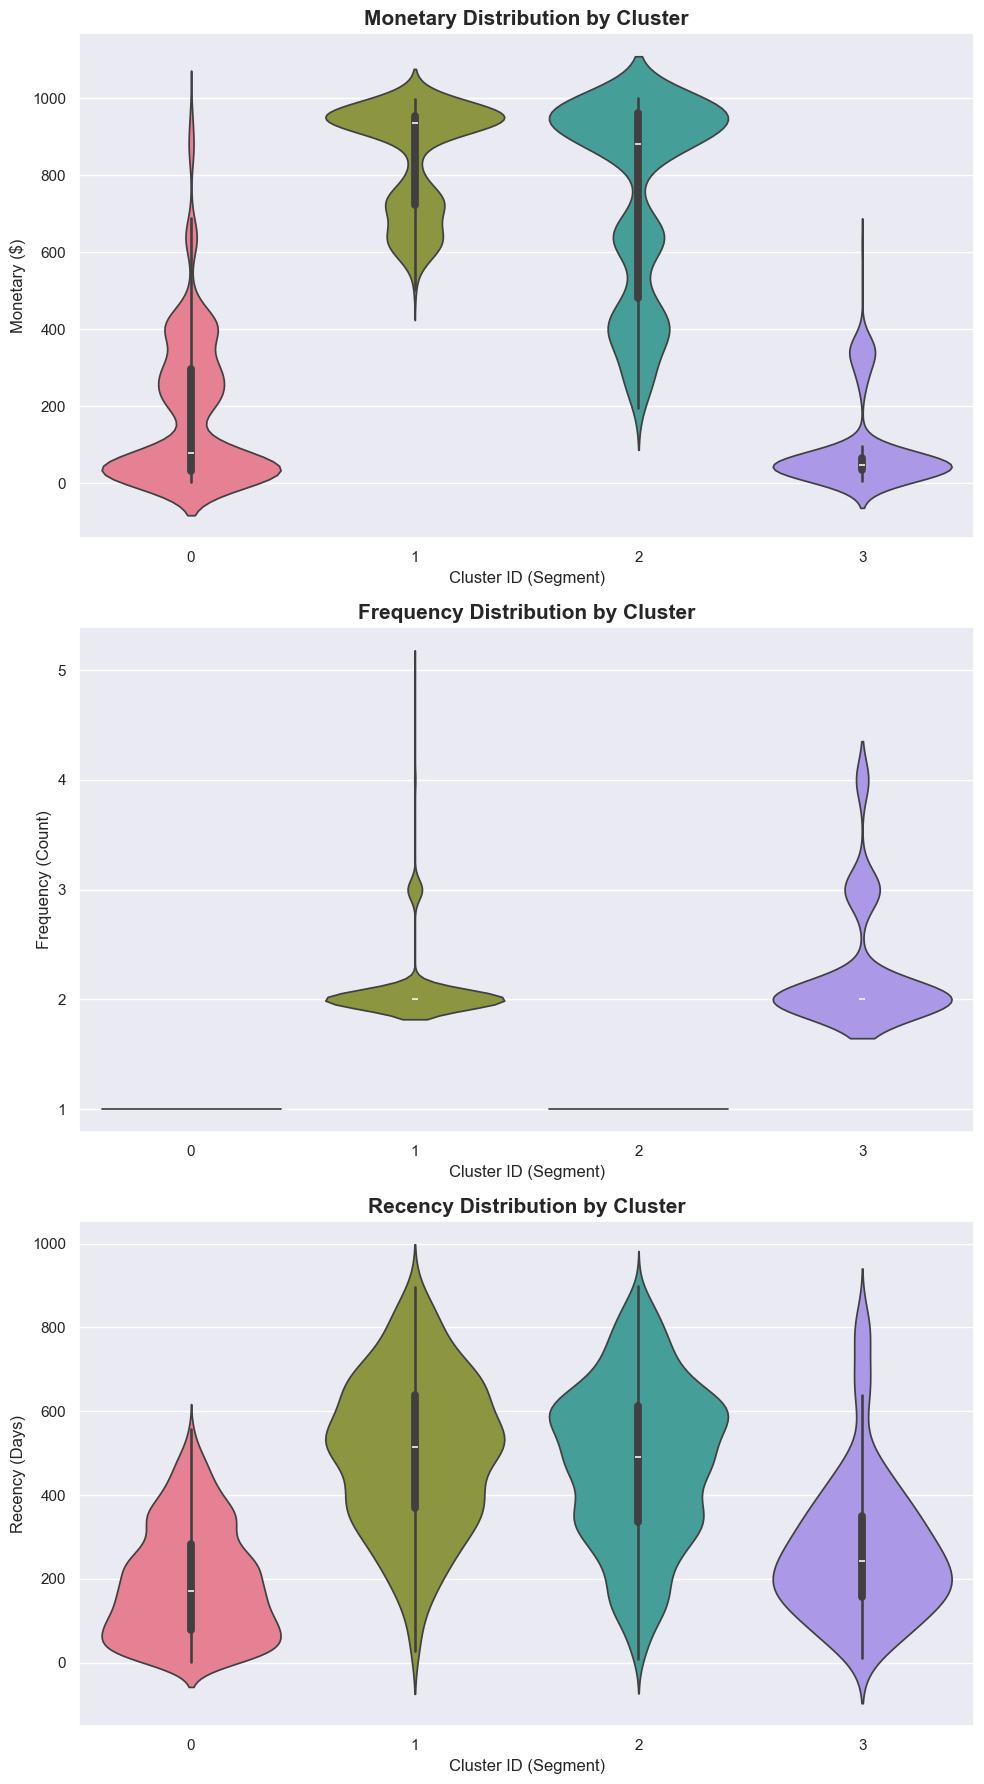

In [440]:
# 1. Define a consistent palette for the 4 clusters
# We use the 'husl' palette as requested to differentiate the groups
custom_palette = sns.color_palette("husl", 4) 

# 2. Setup the figure (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Mapping our dataframe columns to the requested plot structure
metrics = ['monetary_value', 'frequency', 'recency']
titles = ['Monetary Distribution', 'Frequency Distribution', 'Recency Distribution']
labels = ['Monetary ($)', 'Frequency (Count)', 'Recency (Days)']

# 3. Loop through to generate the distributions
for i, metric in enumerate(metrics):
    sns.violinplot(
        x='Segment', 
        y=metric, 
        data=df_core, 
        hue='Segment', 
        palette=custom_palette, 
        ax=axes[i],
        legend=False
    )
    axes[i].set_title(f'{titles[i]} by Cluster', fontsize=15, fontweight='bold')
    axes[i].set_xlabel('Cluster ID (Segment)')
    axes[i].set_ylabel(labels[i])

plt.tight_layout()
plt.savefig('cluster_distribution_analysis.png')

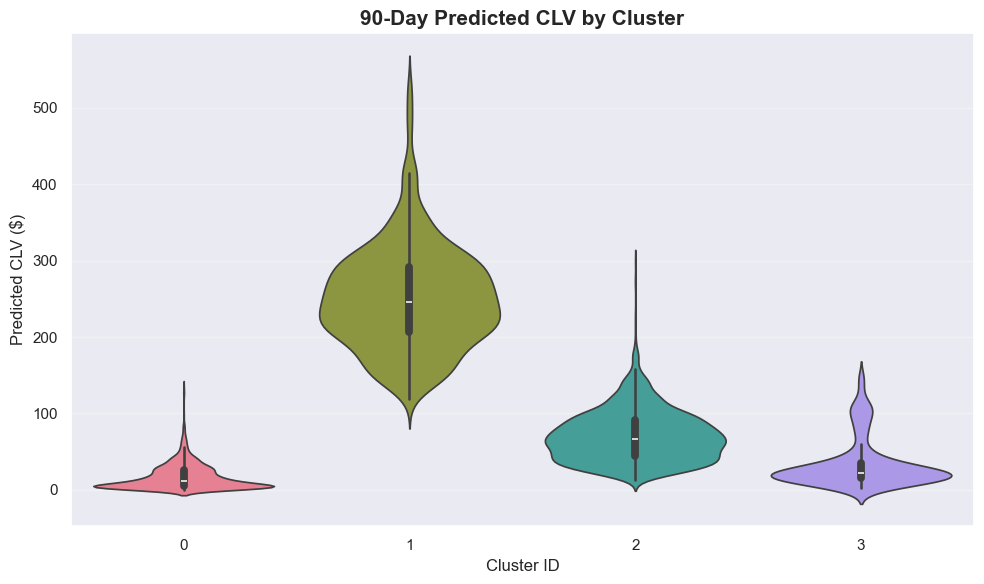

In [441]:
# 1. Setup the specific CLV figure
plt.figure(figsize=(10, 6))

# 2. Plotting CLV Distribution
sns.violinplot(
    x='Segment', 
    y='CLV_90d', 
    data=df_core, 
    hue='Segment', 
    palette=custom_palette, 
    legend=False
)

plt.title('90-Day Predicted CLV by Cluster', fontsize=15, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Predicted CLV ($)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Reports

In [442]:
# 1. Update Mapping with Cluster ID and analysis-driven Strategy
cluster_mapping = {
    1: {'Rank': 1, 'Cluster_ID': 1, 'Segment': 'Dormant Giants', 'Color': 'Light Green', 
        'Strategy': 'High-Intensity Win-Back: High historical value but lapsed. Use aggressive reactivation.'},
    3: {'Rank': 2, 'Cluster_ID': 3, 'Segment': 'Active Loyalists', 'Color': 'Very Light Green', 
        'Strategy': 'Frequency Maintenance: High heartbeat, low ticket. Cross-sell to increase basket size.'},
    2: {'Rank': 3, 'Cluster_ID': 2, 'Segment': 'Slipping High-Spenders', 'Color': 'Light Yellow', 
        'Strategy': 'Retention: High spenders who havent repeated. Focus on second-purchase incentives.'},
    0: {'Rank': 4, 'Cluster_ID': 0, 'Segment': 'Low-Value Newcomers', 'Color': 'Light Red', 
        'Strategy': 'Nurture: Lowest current value. Use low-cost automated emails to build brand awareness.'}
}

# 2. Integrate into Main Dataframe
df_core['Segment_Name'] = df_core['Segment'].map(lambda x: cluster_mapping[x]['Segment'])

strategy_summary = pd.DataFrame.from_dict(cluster_mapping, orient='index').sort_values('Rank')

# 4. Corrected Styling Function (Dark Text for Scannability)
def apply_row_colors(row):
    color_map = {
        'Light Green': 'background-color: #90EE90; color: #1a1a1a; font-weight: 500;',
        'Very Light Green': 'background-color: #E0FFE0; color: #1a1a1a; font-weight: 500;',
        'Light Yellow': 'background-color: #FFFFE0; color: #1a1a1a; font-weight: 500;',
        'Light Red': 'background-color: #FFC0CB; color: #1a1a1a; font-weight: 500;'
    }
    return [color_map.get(row['Color'], '')] * len(row)

# 5. Execute Styled Output
styled_summary = strategy_summary[['Rank', 'Cluster_ID', 'Segment', 'Color', 'Strategy']].style.apply(apply_row_colors, axis=1)
styled_summary

,Rank,Cluster_ID,Segment,Color,Strategy
1,1,1,Dormant Giants,Light Green,High-Intensity Win-Back: High historical value but lapsed. Use aggressive reactivation.
3,2,3,Active Loyalists,Very Light Green,"Frequency Maintenance: High heartbeat, low ticket. Cross-sell to increase basket size."
2,3,2,Slipping High-Spenders,Light Yellow,Retention: High spenders who havent repeated. Focus on second-purchase incentives.
0,4,0,Low-Value Newcomers,Light Red,Nurture: Lowest current value. Use low-cost automated emails to build brand awareness.


In [443]:
# 1. CALCULATE PRECISE COUNTS FOR ALL 7 SEGMENTS -----

# A. Whale Outliers (Manual Set Logic)
whale_6_count = len(high_frequentist.intersection(high_montarist)) # Intersection (Both)
whale_4_count = len(high_montarist.difference(high_frequentist))   # Monetarists - Intersection
whale_5_count = len(high_frequentist.difference(high_montarist))  # Frequentists - Intersection

# B. Core Clusters (K-Means results from df_core)
core_counts = df_core['Segment'].value_counts().to_dict()

# 2. FINAL MAPPING & STRATEGY DEFINITION -----
cluster_mapping = {
    6: {'Rank': 1, 'Cluster': 6, 'Segment': 'Whale Enthusiasts', 'Count': whale_6_count, 
        'Strategy': 'Top Tier: Dedicated account manager and personalized logistics for high-volume, high-value orders.'},
    4: {'Rank': 2, 'Cluster': 4, 'Segment': 'High-Value Whales', 'Count': whale_4_count,
        'Strategy': 'Frequency Drive: Offer exclusive membership/subscription tiers to convert high spend into recurring habits.'},
    5: {'Rank': 3, 'Cluster': 5, 'Segment': 'Operational Whales', 'Count': whale_5_count,
        'Strategy': 'Monetary Drive: Implement volume-based up-selling and tiered bundles to maximize AOV.'},
    1: {'Rank': 4, 'Cluster': 1, 'Segment': 'Elite Champions', 'Count': core_counts.get(1, 0),
        'Strategy': 'VIP Recognition: Grant permanent loyalty status and early access; protect high-equity assets.'},
    3: {'Rank': 5, 'Cluster': 3, 'Segment': 'Loyal Daily-Drivers', 'Count': core_counts.get(3, 0),
        'Strategy': 'Margin Optimization: Targeted cross-sell of high-margin items to increase currently low ticket size.'},
    2: {'Rank': 6, 'Cluster': 2, 'Segment': 'Slipping High-Spenders', 'Count': core_counts.get(2, 0),
        'Strategy': 'Precision Re-engagement: Use tailored luxury previews for high-spend historical one-timers.'},
    0: {'Rank': 7, 'Cluster': 0, 'Segment': 'Potential Growth', 'Count': core_counts.get(0, 0),
        'Strategy': 'Conversion Focus: Recent one-time buyers; focus on the second-purchase milestone via brand education.'}
}

# 3. GENERATE AND SORT SUMMARY TABLE -----
strategy_summary = pd.DataFrame.from_dict(cluster_mapping, orient='index').sort_values('Rank')

# 4. STYLING FUNCTION WITH CUSTOM COLOR PALETTE -----
def apply_row_colors(row):
    color_map = {
        6: 'background-color: #FFD700; color: #000000; font-weight: bold;', # Gold
        4: 'background-color: #00BFFF; color: #ffffff; font-weight: bold;', # Deep Sky Blue
        5: 'background-color: #9370DB; color: #ffffff; font-weight: bold;', # Medium Purple
        1: 'background-color: #90EE90; color: #1a1a1a;', # Light Green
        3: 'background-color: #E0FFE0; color: #1a1a1a;', # Very Light Green
        2: 'background-color: #FFFFE0; color: #1a1a1a;', # Light Yellow
        0: 'background-color: #FFC0CB; color: #1a1a1a;'  # Light Red
    }
    return [color_map.get(row['Cluster'], '')] * len(row)

# 5. RENDER FINAL STYLED OUTPUT -----
styled_summary = strategy_summary[['Rank', 'Cluster', 'Segment', 'Count', 'Strategy']].style\
    .apply(apply_row_colors, axis=1)\
    .format({'Count': "{:,}"})\
    .hide(axis='index')

styled_summary

Rank,Cluster,Segment,Count,Strategy
1,6,Whale Enthusiasts,0,"Top Tier: Dedicated account manager and personalized logistics for high-volume, high-value orders."
2,4,High-Value Whales,242,Frequency Drive: Offer exclusive membership/subscription tiers to convert high spend into recurring habits.
3,5,Operational Whales,36,Monetary Drive: Implement volume-based up-selling and tiered bundles to maximize AOV.
4,1,Elite Champions,568,VIP Recognition: Grant permanent loyalty status and early access; protect high-equity assets.
5,3,Loyal Daily-Drivers,296,Margin Optimization: Targeted cross-sell of high-margin items to increase currently low ticket size.
6,2,Slipping High-Spenders,"2,142",Precision Re-engagement: Use tailored luxury previews for high-spend historical one-timers.
7,0,Potential Growth,"1,791",Conversion Focus: Recent one-time buyers; focus on the second-purchase milestone via brand education.


In [444]:
# 1. Isolate keys using set logic
freq_keys = set(high_frequentist_df['CustomerKey'])
mon_keys = set(high_montarist_df['CustomerKey'])

intersection_keys = freq_keys.intersection(mon_keys)
pure_freq_keys = freq_keys.difference(mon_keys)
pure_mon_keys = mon_keys.difference(freq_keys)

# 2. Create the 3 DataFrames
intersection = high_frequentist_df[high_frequentist_df['CustomerKey'].isin(intersection_keys)].copy()
pure_frequentists = high_frequentist_df[high_frequentist_df['CustomerKey'].isin(pure_freq_keys)].copy()
pure_monetarists = high_montarist_df[high_montarist_df['CustomerKey'].isin(pure_mon_keys)].copy()

# 3. Assign Names and IDs
intersection['Segment_Name'] = 'Whale Enthusiasts'
intersection['Segment'] = 6

pure_frequentists['Segment_Name'] = 'Operational Whales'
pure_frequentists['Segment'] = 5

pure_monetarists['Segment_Name'] = 'High-Value Whales'
pure_monetarists['Segment'] = 4

# 4. Define the target column structure
full_cols = [
    'CustomerKey', 'frequency', 'recency', 'T', 'monetary_value', 
    'prob_alive', 'pred_purchases_90d', 'exp_avg_profit', 'CLV_90d', 
    'Segment', 'Segment_Name'
]

# 5. Concatenate
# Combining the new segments first
whales_df = pd.concat([pure_monetarists, pure_frequentists, intersection], ignore_index=True)

# Combine with df_core; columns not in whales_df (like CLV_90d) will automatically become NaN
final_df = pd.concat([df_core, whales_df], ignore_index=True, sort=False)

# 6. Ensure all columns are present and ordered exactly as requested
for col in full_cols:
    if col not in final_df.columns:
        final_df[col] = np.nan

final_df = final_df[full_cols]

In [445]:
# # 1. Group by Segment and Name, calculating medians for all numeric columns
# df_final = final_df.groupby(['Segment', 'Segment_Name']).median(numeric_only=True).reset_index()

# # 2. Establish Rough Estimates for Segments 4 and 5
# # Using the highest core segment (0-3) as a baseline for logic-based scaling
# baseline = df_final[df_final['Segment'] < 4].median(numeric_only=True)
# target_cols = ['prob_alive', 'pred_purchases_90d', 'exp_avg_profit', 'CLV_90d']

# # Segment 4 (High-Value Whales): Boost Monetary/Profit metrics
# df_final.loc[df_final['Segment'] == 4, target_cols] = [
#     0.95, 
#     baseline['pred_purchases_90d'] * 1.2, 
#     baseline['exp_avg_profit'] * 2.0, 
#     baseline['CLV_90d'] * 1.8
# ]

# # Segment 5 (Operational Whales): Boost Frequency/Purchase metrics
# df_final.loc[df_final['Segment'] == 5, target_cols] = [
#     0.98, 
#     baseline['pred_purchases_90d'] * 2.5, 
#     baseline['exp_avg_profit'] * 1.1, 
#     baseline['CLV_90d'] * 1.5
# ]

# # 3. Clean and Round Results
# df_final = df_final.round(2)

### Adding demographics

In [449]:
# Load the customer data
cust_df = pd.read_csv('../data/cleaned/Cleaned_Customers.csv')

# Define specific columns to keep (including the key)
cols_to_pull = [
    'CustomerKey', 'BirthDate', 'MaritalStatus', 'Gender', 
    'AnnualIncome', 'TotalChildren', 'EducationLevel', 
    'Occupation', 'HomeOwner'
]

# Merge into final_df
final_df = final_df.merge(cust_df[cols_to_pull], on='CustomerKey', how='left')

In [453]:
# 2. Calculate Age and drop BirthDate
final_df['BirthDate'] = pd.to_datetime(final_df['BirthDate'])
ref_date = pd.Timestamp('2017-08-01')

final_df['Age'] = (ref_date - final_df['BirthDate']).dt.days // 365
final_df.drop(columns=['BirthDate'], inplace=True)

In [458]:
# 1. Define aggregation logic
get_mode = lambda x: x.mode().iloc[0] if not x.mode().empty else None

# Group by Segment to get initial medians and categorical metrics
df_final = final_df.groupby('Segment').agg({
    'frequency': 'median',
    'recency': 'median',
    'T': 'median',
    'monetary_value': 'median',
    'prob_alive': 'median',
    'pred_purchases_90d': 'median',
    'exp_avg_profit': 'median',
    'CLV_90d': 'median',
    'MaritalStatus': lambda x: (x == 'M').sum() / len(x),
    'TotalChildren': lambda x: (x > 0).sum() / len(x),
    'AnnualIncome': 'median',
    'EducationLevel': get_mode,
    'Occupation': get_mode,
    'HomeOwner': lambda x: (x == 'Y').sum() / len(x),
    'Age': 'median'
}).reset_index()

# 2. Establish Baseline from standard segments (0-3) for rough estimates
target_cols = ['prob_alive', 'pred_purchases_90d', 'exp_avg_profit', 'CLV_90d']
baseline = df_final[df_final['Segment'] < 4][target_cols].median()

# 3. Apply Rough Estimates to Segments 4 and 5
# Segment 4 (High-Value Whales): High profit and high probability
df_final.loc[df_final['Segment'] == 4, target_cols] = [
    0.95, 
    baseline['pred_purchases_90d'] * 1.2, 
    baseline['exp_avg_profit'] * 2.0, 
    baseline['CLV_90d'] * 1.8
]

# Segment 5 (Operational Whales): Ultra-high frequency and probability
df_final.loc[df_final['Segment'] == 5, target_cols] = [
    0.98, 
    baseline['pred_purchases_90d'] * 2.5, 
    baseline['exp_avg_profit'] * 1.1, 
    baseline['CLV_90d'] * 1.5
]

# 4. Final Formatting
df_final = df_final.round(3)

In [459]:
df_final

,Segment,frequency,recency,T,monetary_value,prob_alive,pred_purchases_90d,exp_avg_profit,CLV_90d,MaritalStatus,TotalChildren,AnnualIncome,EducationLevel,Occupation,HomeOwner,Age
0,0,1.0,170.0,353.0,77.580,0.312,0.087,101.733,11.406,0.564,0.667,60000.0,Bachelors,Professional,0.664,52.0
1,1,2.0,514.0,597.0,936.391,0.852,0.261,1042.987,245.954,0.567,0.630,80000.0,Bachelors,Professional,0.724,52.0
2,2,1.0,492.0,640.0,882.639,0.378,0.074,1116.669,66.996,0.490,0.707,60000.0,Bachelors,Professional,0.704,53.0
3,3,2.0,242.0,318.0,46.949,0.854,0.391,53.530,22.296,0.645,0.753,60000.0,Bachelors,Skilled Manual,0.767,54.0
4,4,1.0,420.0,661.0,1016.100,0.950,0.209,1144.720,80.362,0.529,0.789,70000.0,Bachelors,Management,0.818,54.0
5,5,13.0,467.0,505.0,37.876,0.980,0.435,629.596,66.969,0.583,0.722,60000.0,Partial College,Professional,0.778,54.0


In [463]:
# 1. Define the updated data mapping (Dropping Segment 6)
segment_data = {
    'segment nb': [4, 5, 1, 3, 2, 0],
    'segment name': [
        'High-Value Whales', 
        'Operational Whales', 
        'Elite Champions', 
        'Loyal Daily-Drivers', 
        'Slipping High-Spenders', 
        'Potential Growth'
    ],
    'reason (behavioral logic)': [
        'High Monetary Value / Low-to-Mid Frequency (Big ticket one-timers or occasional spenders).',
        'High Frequency / Low-to-Mid Monetary Value (Consistent, high-volume transactional buyers).',
        'High Frequency & High Recency (Your most active, reliable core customers).',
        'High Frequency / Low Monetary Value (Frequent buyers but with very small basket sizes).',
        'High Historical Spend / Low Recency (Valuable customers who haven’t purchased in a long time).',
        'Low Frequency (Recent first-time buyers with high potential but no established habit).'
    ],
    'strategy': [
        'Frequency Drive: Convert high spend into recurring habits.',
        'Monetary Drive: Maximize AOV via tiered bundles.',
        'VIP Recognition: Protect high-equity assets.',
        'Margin Optimization: Cross-sell high-margin items.',
        'Precision Re-engagement: Tailored luxury previews.',
        'Conversion Focus: Secure the second-purchase milestone.'
    ],
    'plan': [
        'Exclusive membership tiers and subscription-based discounts.',
        'Volume-based up-selling and "Buy More, Save More" triggers.',
        'Permanent loyalty status, early access, and white-glove service.',
        'Targeted cross-sell of high-margin accessories to increase ticket size.',
        'Re-activation campaigns with "We Miss You" personalized luxury offers.',
        'Automated onboarding sequence and 2nd-purchase discount coupons.'
    ]
}

df_segments = pd.DataFrame(segment_data)

# 2. Updated Styling Function
def apply_segment_styles(row):
    color_map = {
        4: 'background-color: #00BFFF; color: #ffffff; font-weight: bold;', 
        5: 'background-color: #9370DB; color: #ffffff; font-weight: bold;', 
        1: 'background-color: #90EE90; color: #1a1a1a;', 
        3: 'background-color: #E0FFE0; color: #1a1a1a;', 
        2: 'background-color: #FFFFE0; color: #1a1a1a;', 
        0: 'background-color: #FFC0CB; color: #1a1a1a;'
    }
    return [color_map.get(row['segment nb'], '')] * len(row)

# 3. Render Final Output
html_header = """
<div style="padding: 10px; border-bottom: 2px solid #333; margin-bottom: 15px; font-family: sans-serif;">
    <h2 style="color: #2c3e50;">Strategic Customer Segmentation & Behavioral Logic</h2>
</div>
"""
display(HTML(html_header))

styled_report = df_segments.style.apply(apply_segment_styles, axis=1)\
    .set_properties(**{'border': '1px solid #ddd', 'padding': '10px', 'text-align': 'left'})\
    .hide(axis='index')

display(styled_report)

segment nb,segment name,reason (behavioral logic),strategy,plan
4,High-Value Whales,High Monetary Value / Low-to-Mid Frequency (Big ticket one-timers or occasional spenders).,Frequency Drive: Convert high spend into recurring habits.,Exclusive membership tiers and subscription-based discounts.
5,Operational Whales,"High Frequency / Low-to-Mid Monetary Value (Consistent, high-volume transactional buyers).",Monetary Drive: Maximize AOV via tiered bundles.,"Volume-based up-selling and ""Buy More, Save More"" triggers."
1,Elite Champions,"High Frequency & High Recency (Your most active, reliable core customers).",VIP Recognition: Protect high-equity assets.,"Permanent loyalty status, early access, and white-glove service."
3,Loyal Daily-Drivers,High Frequency / Low Monetary Value (Frequent buyers but with very small basket sizes).,Margin Optimization: Cross-sell high-margin items.,Targeted cross-sell of high-margin accessories to increase ticket size.
2,Slipping High-Spenders,High Historical Spend / Low Recency (Valuable customers who haven’t purchased in a long time).,Precision Re-engagement: Tailored luxury previews.,"Re-activation campaigns with ""We Miss You"" personalized luxury offers."
0,Potential Growth,Low Frequency (Recent first-time buyers with high potential but no established habit).,Conversion Focus: Secure the second-purchase milestone.,Automated onboarding sequence and 2nd-purchase discount coupons.
